In [1]:
import re
import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from collections import Counter
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

# Оригинальный датасет с банковскими комментариями недоступен на дропбоксе. Взял комментарии кинопоиска по [ссылке](https://drive.google.com/open?id=1gJEpwM3zdV5xe9nRU0VwQmGTiOTQdp10)

In [9]:
df = pd.read_csv('reviews.csv')
df.head()

,label,text
0,1,Эпиграф Добро которое ты делаешь от сердца ты ...
1,1,Теперь это один из моих любимых фильмов в жанр...
2,1,Что скрыто в фильме Лучше не бывает Одна шикар...
3,1,Перед нами очень милое и доброе кино которое л...
4,1,Завязка Мелвин Удал популярный писатель Нет не...


In [4]:
df.label.value_counts()

 1    36480
 0     5645
-1     4376
Name: label, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46501 entries, 0 to 46500
Data columns (total 2 columns):
label    46501 non-null int64
text     46501 non-null object
dtypes: int64(1), object(1)
memory usage: 726.7+ KB


## 46к отзывов, 3 типа меток - положительные, нейтральные и отрицательные. Датасет несбалансирован по кол-ву классов.

In [32]:
#Small preprocessing - all to low case. 
df.text = df.text.apply(lambda x: x.lower())

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### 1. Посчитайте количество отзывов в разных городах и на разные банки 
### Не применимо, другой датасет

### 2. Постройте гистограмы длин слов в символах и в словах - непонятно. Построил гистограммы длин отзывов в словах и символах

In [7]:
char_count = [0] * len(df)
word_count = [0] * len(df)
for i, cur_t in enumerate(df.text):
    char_count[i] = len(cur_t)
    word_count[i] = len(cur_t.split()) #знаки препинания удалили до меня

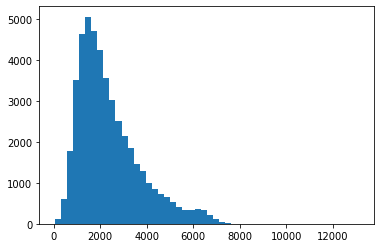

In [8]:
plt.hist(char_count, bins=50, label='Длина отзыва в символах')
plt.show()

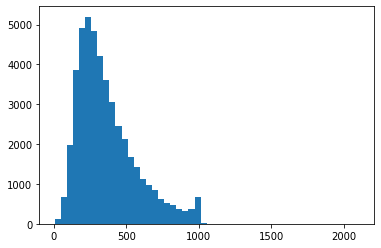

In [9]:
plt.hist(word_count, bins=50, label='Длина отзыва в словах')
plt.show()

### Необычное поведение около 1000 слов - видимо ограничение длины сообщения

### 3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных

In [10]:
#Words

corpus = [word for comment in df.text for word in comment.split()] #текст предобработан, поэтому сработает
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('и', 645076),
 ('в', 449243),
 ('не', 351648),
 ('что', 215199),
 ('на', 213878),
 ('с', 163190),
 ('-', 125328),
 ('как', 118821),
 ('это', 116598),
 ('из', 103986)]

In [4]:
#Without stop words

my_stop = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', 'фильм', 'вс', 'весь'
]
#ФИльм, вс и весь удаляются для дальнейшего анализа

In [33]:
#Without stop words
corpus = [word for comment in df.text for word in comment.split() if word not in my_stop] #текст предобработан, поэтому сработает
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('-', 125328),
 ('очень', 54420),
 ('фильма', 50681),
 ('просто', 40110),
 ('фильме', 31363),
 ('всё', 29989),
 ('кино', 27563),
 ('которые', 26315),
 ('жизни', 25492),
 ('время', 24231)]

In [5]:
#Lemmas counting. I have laptop with WIndows, so mystem is too slooooow. Will use pymorph and save result to file

pymorphy2_analyzer = MorphAnalyzer()


# mystopwords = stopwords.words('russian') + [
#     'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
#     'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
# ]

ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text):
    out_tok = []
    try:
        tok_list = word_tokenize(text)
        for w in tok_list:
            out_tok.append(pymorphy2_analyzer.parse(w)[0].normal_form)
        return " ".join(out_tok)  
    except:
        return " "


def remove_stopwords(text, mystopwords = my_stop):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text)))

In [ ]:
tqdm.tqdm_pandas(tqdm.tqdm, leave=True)
df['lemm_text'] = df.text.progress_apply(preprocess)

In [ ]:
df.head()

In [ ]:
# df.to_csv('reviews_lemmed.csv')

In [46]:
#Loading preprocessed file
df = pd.read_csv('reviews_lemmed.csv', index_col=0, usecols=[0, 1, 3])

In [48]:
#Дальнейший анализ показал, что слова "фильм", "весь" и "вс" (от "всё") нужно тоже внести в стоп-слова
# Just run function again - don't want to lemmatize full text again

df.lemm_text = df.lemm_text.apply(remove_stopwords)

In [49]:
df.head()

,label,lemm_text
0,1,эпиграф добро делать сердце делать литр толсто...
1,1,любимый жанр жанр преимущество отдавать именно...
2,1,скрытый хороший бывать шикарный мысль строчка ...
3,1,очень милый добрый кино лично смотреть участие...
4,1,завязка мелвин удалый популярный писатель мелв...


In [50]:
corpus = [word for comment in df.lemm_text for word in comment.split()] #текст предобработан, поэтому сработает
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('человек', 74156),
 ('самый', 59516),
 ('герой', 57077),
 ('очень', 54916),
 ('хороший', 49542),
 ('жизнь', 48471),
 ('время', 41528),
 ('просто', 40400),
 ('история', 39769),
 ('картина', 39266)]

In [51]:
#Noun counting
counter = 0
top_words = freq_dict.most_common(100)
top_nouns = []

for cur_word in top_words:
    if pymorphy2_analyzer.parse(cur_word[0])[0].tag.POS == 'NOUN':
        top_nouns.append(cur_word)
        counter += 1
        if counter >= 10:
            break
            
top_nouns

[('человек', 74156),
 ('герой', 57077),
 ('жизнь', 48471),
 ('время', 41528),
 ('история', 39769),
 ('картина', 39266),
 ('год', 35090),
 ('персонаж', 31502),
 ('сюжет', 30997),
 ('роль', 30948)]

### 4. Постройте кривые Ципфа и Хипса

In [52]:
word_count = [0] * len(df)
for i, cur_t in enumerate(df.lemm_text):
    word_count[i] = len(cur_t.split()) #знаки препинания удалили до меня
    
total_words = np.sum(word_count)
total_words

10133074

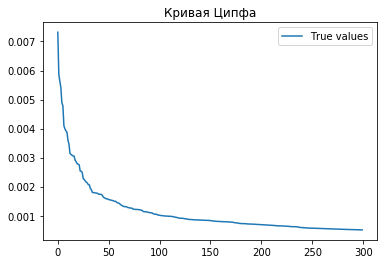

In [53]:

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

EMP_FREQ = 0.007 #empirical frequency for slavic language

fig, ax = plt.subplots()
ax.plot(freqs[:300]/total_words, label='True values')#, range(300))
ax.legend()
ax.set_title('Кривая Ципфа')
plt.show()

In [54]:
cnt = Counter()
n_tokens = [0]
n_words = [0]

for idx, cur_text in tqdm.tqdm(df.iterrows(), total=len(df)):
    cur_words = word_tokenize(cur_text.lemm_text)
    cnt.update(cur_words)
    n_words.append(n_words[-1]+len(cur_words))
    n_tokens.append(len(cnt.values()))
    


100%|███████████████████████████████████| 46501/46501 [03:28<00:00, 223.43it/s]


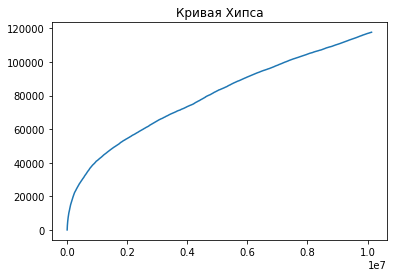

In [55]:
fig, ax = plt.subplots()
ax.plot(n_words, n_tokens)
ax.set_title('Кривая Хипса')
plt.show()

In [15]:
#Выведем наиболее редкие слова - это, в основном, "новообразованные" слова и опечатки
sorted(freq_dict.most_common(), key=lambda x: x[1])[:20]

[('басовито', 1),
 ('трабла', 1),
 ('нюнислюни', 1),
 ('маникальный', 1),
 ('аллергик', 1),
 ('мелвиновский', 1),
 ('юдеть', 1),
 ('пси', 1),
 ('кинера', 1),
 ('мдвина', 1),
 ('джекобсон', 1),
 ('эдельштейн', 1),
 ('бенц', 1),
 ('прокусок', 1),
 ('левш', 1),
 ('участнок', 1),
 ('воспронимать', 1),
 ('загриммированный', 1),
 ('невпервые', 1),
 ('осноном', 1)]

### 5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [59]:
print('Слово "сотрудник" встретилось %d раз, слово "клиент" - %d раз'
      % (freq_dict.get('сотрудник'), freq_dict.get('клиент')))

Слово "сотрудник" встретилось 435 раз, слово "клиент" - 363 раз


In [60]:
print('Слово "мошенничество" встретилось %d раз, слово "доверие" - %d раз'
      % (freq_dict.get('мошенничество'), freq_dict.get('доверие')))

Слово "мошенничество" встретилось 99 раз, слово "доверие" - 612 раз


### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Другой датасет, поэтому оценка 1 и -1

In [108]:
vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
log_reg = LogisticRegression()
log_reg.fit(bow, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [127]:
max_args = np.argsort(log_reg.coef_[0])[:10]
for idx in max_args:
    print(vec.get_feature_names()[idx])

ничто
вообще
почему
скучный
никакой
плохой
идея
видимо
плохо
вместо


In [128]:
max_args = np.argsort(log_reg.coef_[0])[-10:]
for idx in max_args:
    print(vec.get_feature_names()[idx])

отлично
потрясать
самый
отличный
прекрасный
очень
замечательный
роль
жизнь
каждый


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer(ngram_range=(1,2))
vec.fit(df[df.label==1].lemm_text)

In [ ]:
x = vec.transform([df.iloc[100].lemm_text])

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [16]:
texts = [text.split() for text in df.lemm_text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [17]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [18]:
from gensim.models import lsimodel


In [19]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 0 ns


In [22]:
lsi.show_topics()

[(0,
  '0.081*"очень" + 0.080*"жизнь" + 0.080*"человек" + 0.078*"картина" + 0.076*"мультфильм" + 0.075*"друг" + 0.075*"история" + 0.073*"часть" + 0.071*"герой" + 0.070*"персонаж"'),
 (1,
  '-0.796*"мультфильм" + -0.173*"мультик" + -0.140*"ребёнок" + -0.101*"взрослый" + -0.096*"анимация" + -0.095*"дисней" + -0.084*"игрушка" + -0.078*"сказка" + -0.077*"миядзак" + -0.076*"студия"'),
 (2,
  '0.210*"часть" + 0.176*"мультфильм" + -0.167*"жизнь" + -0.161*"любовь" + -0.132*"ребёнок" + -0.106*"жить" + -0.100*"человек" + 0.096*"боевик" + 0.092*"персонаж" + -0.092*"женщина"'),
 (3,
  '0.386*"война" + -0.134*"актёр" + -0.132*"комедия" + 0.111*"солдат" + 0.108*"часть" + -0.104*"роль" + 0.094*"военный" + -0.094*"очень" + -0.092*"сыграть" + -0.092*"игра"'),
 (4,
  '0.283*"книга" + 0.241*"часть" + 0.222*"гарри" + -0.198*"мультфильм" + 0.157*"поттер" + -0.135*"война" + 0.120*"ребёнок" + 0.100*"сказка" + 0.094*"кольцо" + -0.082*"тарантино"'),
 (5,
  '-0.481*"война" + -0.174*"книга" + 0.151*"робот" + -0.

### При 30 темах интерпретировать достаточно легко)) 30я вообще описывает актеров

In [24]:
#let's try 100

lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

In [25]:
lsi.show_topics(10)

[(0,
  '0.081*"очень" + 0.080*"жизнь" + 0.080*"человек" + 0.078*"картина" + 0.076*"мультфильм" + 0.075*"друг" + 0.075*"история" + 0.073*"часть" + 0.071*"герой" + 0.070*"персонаж"'),
 (1,
  '-0.797*"мультфильм" + -0.173*"мультик" + -0.139*"ребёнок" + -0.100*"взрослый" + -0.096*"дисней" + -0.096*"анимация" + -0.087*"игрушка" + -0.079*"сказка" + -0.076*"студия" + -0.075*"добрый"'),
 (2,
  '0.205*"часть" + 0.189*"мультфильм" + -0.169*"жизнь" + -0.157*"любовь" + -0.141*"ребёнок" + -0.106*"жить" + -0.099*"человек" + 0.093*"боевик" + 0.093*"персонаж" + 0.089*"франшиза"'),
 (3,
  '0.422*"война" + -0.152*"комедия" + -0.126*"актёр" + 0.123*"солдат" + 0.106*"военный" + -0.100*"роль" + -0.087*"сыграть" + -0.086*"очень" + -0.084*"игра" + 0.082*"часть"'),
 (4,
  '0.243*"часть" + 0.224*"гарри" + 0.217*"книга" + 0.184*"белла" + 0.161*"поттер" + -0.157*"мультфильм" + 0.154*"вампир" + -0.135*"война" + 0.124*"кольцо" + 0.119*"ребёнок"'),
 (5,
  '-0.324*"война" + -0.179*"советский" + -0.134*"книга" + 0.12

### Может быть даже проще интерпретировать - каждая тема относится к 2-3 фильмам.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [98]:
df.label.value_counts()

 1    36480
 0     5645
-1     4376
Name: label, dtype: int64

In [57]:
dataset = pd.concat([df[df.label==1].sample(4500), df[df.label==-1]], ignore_index=True)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(dataset.lemm_text, dataset.label, 
                                                    test_size=0.25, random_state=42)

In [104]:
#with 1-1 ngram
clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1))),
    ('svd', TruncatedSVD(n_components=100)),
    ('logreg', LogisticRegression())
])

In [105]:
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(classification_report(y_test, preds))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

          -1       0.90      0.88      0.89      1097
           1       0.88      0.90      0.89      1122

    accuracy                           0.89      2219
   macro avg       0.89      0.89      0.89      2219
weighted avg       0.89      0.89      0.89      2219



In [102]:
# with 1-2 ngram
clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('svd', TruncatedSVD(n_components=100)),
    ('logreg', LogisticRegression())
])
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(classification_report(y_test, preds))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

          -1       0.88      0.86      0.87      1097
           1       0.87      0.89      0.88      1122

    accuracy                           0.87      2219
   macro avg       0.88      0.87      0.87      2219
weighted avg       0.87      0.87      0.87      2219



In [103]:
# with char ngram
clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(4,6), analyzer='char')),
    ('svd', TruncatedSVD(n_components=100)),
    ('logreg', LogisticRegression())
])
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(classification_report(y_test, preds))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

          -1       0.88      0.86      0.87      1097
           1       0.87      0.89      0.88      1122

    accuracy                           0.88      2219
   macro avg       0.88      0.88      0.88      2219
weighted avg       0.88      0.88      0.88      2219

